### Reminder of the aim

We want to put an upper bound on the sensitivity of the function,

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j)$$

Where $a_i$ is the $i$th element of the $\mathbf{a} = K^{-1}y$ vector.

And $k(.,.)$ is the kernel function.

We obviously want to find a bound for $a_i$ and for the sum over $k(.,.)$s.

We first consider $K^{-1}y$;

### Bound on elements of $K^{-1}y$

If we consider the case of two positively correlated variables (zero mean). We can see that the two eigenvectors will lie in the [1,1] and [-1,1] direction. The more correlated the two variables, the smaller the smallest eigenvalue will be.

<img src="correlation_example1.png">


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_shape(corr):
    X = np.random.multivariate_normal(np.zeros(corr.shape[0]),corr,20000)
    plt.plot(X[:,0],X[:,1],'.',markersize=1)
    plt.axis('equal')
    plt.grid('on')
    plt.axes()
    plt.title('Example covariance pattern formed by variables of %d dimensions' % corr.shape[0])
    eig_val, eig_vec = np.linalg.eig(corr)
    for i in range(len(eig_val)):
        ev = eig_vec[:,i]*eig_val[i]*2
        plt.plot([0,ev[0]],[0,ev[1]],'k-')
plot_shape(np.array([[1,0.5],[0.5,1]]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plot_shape(np.array([[1,0.4,0.4],[0.4,1,0.4],[0.4,0.4,1]]))

#The scaled eigenvectors are projected onto the 2d x,y plane.

One can imagine how this extends to further dimensions, with each dimension (with correlation) added making the smallest eigenvalue even smaller. 

However, the eigenvectors will no longer face in the [1,-1,...] directions. In the figure above, one can see that the two smaller eigenvectors are not in any of the [1,-1...1] directions.

The largest value that $\mathbf{y}$ can provide is bounded along the surfaces of the $-1$ to $+1$ hypercube. The eigenvectors don't (generally) point in these directions (e.g. [-1,+1,+1,+1]). So the largest value of $K^{−1}y$ will involve the combination of several eigenvalues/vectors.

This figure tries to illustrate this. Note that the output of the largest eigenvalue has been normalised to one, to allow easy comparison.



<img src="correlation_example2.png">

In the above figure, it is the reprojection into the space of the eigenvectors, combined with the sum of the eigenvector contributions, means that some elements of the output vector can be larger than one.

In [ ]:
#We roughly mirror the above calculation

def dotransform(corr):
    G = np.linalg.inv(corr)
    U,L,V = np.linalg.svd(G)
    #normalise to reflect figure
    L = L/np.max(L)
    old_v = np.array([[1,-1]]).T
    print "original:    (%0.2f,%0.2f)" % (old_v[0],old_v[1])
    v = old_v
    #step by step (originally used to illustrate the steps of the SVD)
    v = np.dot(V,v)
    v = np.dot(np.diag(L),v)
    print "UVv:         (%0.2f,%0.2f)" % (v[0],v[1])
    v = np.dot(U,v)

    print "transformed: (%0.2f,%0.2f)" % (v[0],v[1])
    
print "For the example on the left (equal variance, 'angle' at 45 degrees)"
dotransform(np.array([[1,0.5],[0.5,1]]))
print "For the example on the right (unequal variance)"
dotransform(np.array([[1,0.25],[0.25,0.3]]))

We can consider the amount a vector could be scaled, and it seems likely that **an upperbound will be $\sqrt{\sum \lambda_i^2}$.**

Note: Interestingly, in the limit of a large number of equally spaced points, it seems that the largest value in the $K^{−1}y$ vector **is** equal to the inverse of the smallest eigenvalue in $K^{-1}$. 

In summary: For now I'll assume that the largest value in the vector $K^{−1}y$ is roughly equal to the maximum eigenvalue of $K^{-1}$.

The following code demonstrates these bounds for an arbitrary number of dimensions. Points are places on a **square grid** (closest packing would be interesting, but packings at higher dimensions have not been proved or known).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def kern(a,b): 
    a1 = x.repeat(x.shape[1],axis=1)
    b1 = np.tile(x,x.shape[1])
    return np.exp(-np.sum((a1-b1)**2,axis=0)).reshape(x.shape[1],x.shape[1])

N = 6 #number of steps in each dimension
dims = 4 #number of dimensions
dist = 1.4 #distance between points
x = np.arange(0,N)*dist

Ntot = 1
for it in range(dims-1):
    Ntot = Ntot * N
    x = np.vstack([np.tile(x,N),(np.arange(0,N)*dist).repeat(Ntot)])
    
K = kern(x,x)
G = np.linalg.inv(K)

print "Number of steps: %d. Number of dimensions: %d. Distance between points %0.2f" % (N,dims,dist)
print "Maxmimum value in G (for later analysis) = %0.4f" % np.max(G)
print "Maximum value in Gy (for -1<y<1) = %0.4f" % (np.max(np.sum(np.abs(G),axis=0)))
eigenvalues, _ = np.linalg.eig(K)
print "1/smallest eigenvalue = %0.4f" % (1.0/np.min(eigenvalues))
print "euclidean distance = %0.4f" % np.sqrt(np.sum((1.0/eigenvalues)**2))

Some example results:

| Number of dimensions | Number of points in each dimension | Minumum distance between points | Actual maximum value in $K^{-1}y$ | Inverse of smallest eigenvalue  ($1/\lambda$) | Length of combined eigenvalues $\sqrt{\sum \lambda_i^2}$ | Notes |
|----------------------|------------------------------------|---------------------------------|-----------------------------------|-----------------------------------------------|----------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| 3 | 5 | 1 | 25.9 | 17.7 | 38.0 | When only a few points are close together, the approximate value ($1/\lambda$) does not work. |
| 3 | 9 | 1 | 35.2 | 27.7 | 108.4 | With enough points, it starts to approach the correct value. The correct bound becomes very poor (too big). |
| 3 | 15 | 1 | 36.72 | 32.87 | 253.02 | In the limit the $1/\lambda_{min}$ bound (for an infinite number of points) starts to be ideal, for any number of points. |
| 2 | 50 | 1 | 11.1 | 11.0 | 140.4 | Another example of the above bound working, using 2d data. |
| 2 | 3 | 1 | 5.5 | 4.2 | 5.7 | |
| 3 | 10 | 10 | 1.00 | 1.00 | 11.18 | Putting the points far apart. Again, the 'correct' bound is much larger than the real value. |
| 3 | 5 | 2 | 1.118 | 1.101 | 11.207 | Just enough distance makes our approximation reasonable. |
| 6 | 3 | 2 | 1.246 | 1.17 | 27.11 | Even with lots of dimensions the approximation isn't far off. |
| 6 | 3 | 1.6 | 2.55 | 2.00 | 29.02 | The result is sensitive to this distance, and is weaker at higher dimensions. |

$y$ is assumed to be between -1 and 1 in the above.

It is worth noting that the tightest bound seems to be $1/\lambda_{min}$ for an infinite number of points. The more easily computed $\sqrt{\sum \lambda_i^2}$ is however a valid upper bound, but is unreasonably large for many cases.

For my purposes I'll state that:

the largest value of an element in $\mathbf{a} = K^{-1}\mathbf{y}$ is bounded by $|a_i| \leq 2 \times y_{max}$. We just need to select the distance between points such that this bound is preserved.

For two dimensions this distance is 1.4 $\times$ length scale.

This seems a long way apart, but hopefully, by using inducing points, this constraint won't be too serious. If it is we can switch to using the above calculated bounds. We would need to be careful in that case as the noise statistics will hold information about the data.

### Possible other bound?

<small>Note: Ideally, if we put a bound on how correlated each pair of variables is (i.e. by proximity of points), how do we find a bound for the largest eigenvalue in the $K^{-1}$ matrix? We can use this as an alternative way of making a bound by noting that all the other eigenvalues are equal or less to this value, so the scaling effect of the transform will be bounded by $\sqrt{N_{inputs} \times \lambda_{max}^{2}}$. (where $\lambda_{max}$ is the largest eigenvalue in the inverse covariance matrix).</small>

### Size of the kernel value

The equation above depends on summing over a set of kernels (scaled by the above values). What bounds can we set on this sum?

$\sum_i \sum_j k(x_i, x_j)$

We have decreed that the points $\mathbf{x}$ are placed at least $d$ apart. So the sum of (stationary) kernels will be bounded.

$e^{-1^2} + e^{-2^2} +\;... $

This looks like the integral of a gaussian.

We can put an upper bound on the sum.

If we note that the sum geometrically looks like the shaded area of this figure:

<img src="integrate.png">

We can note that the first block has a height of one, then the following are bounded by ${}^1/_2 \times Area$ (of a gaussian). We can extend this for arbitrary distances between inputs, leading to:

$$\sum_{i=0}^{\infty} e^{-(\Delta i)^2} \leq 1 + {{\sqrt{\pi}} \over 2 \delta}$$


In [ ]:
#Numerical demonstration for different values of delta (distance between inputs)

#in particular looking at how far from the bound the summation is.
import numpy as np
deltas = np.arange(0.01,20,0.01)
temp = np.zeros_like(deltas)
for en,delta in enumerate(deltas):
    i = np.arange(10000)*delta
#    print delta
#    print i[0:5]
#    print np.sum(np.exp(-i**2))
#    print 1.0+(np.sqrt(np.pi))/(2.0*delta)
    temp[en] = (1+(np.sqrt(np.pi))/(2.0*delta)) /np.sum(np.exp(-i**2))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(deltas,temp)
plt.title('Error (ratio) of bound')
plt.xlabel('Distance between inputs')
plt.ylabel('Error ratio')
#as one might expect. For very small delta, the summation approximates the integral.
#for large delta, the inputs are so far apart, after the initial "1" the rest are approximately zero.

### Putting it together

To summarise,

We using the approximation that there are no elements in $\mathbf{a}$ above a certain bound, i.e. $|a_i| \leq 2 y_{max}$. The sum of the kernels is bounded by $1 + {{\sqrt{\pi}} \over 2 \delta}$. Putting these together in:

$$\sum_i \sum_j a_i a_j k(x_i, x_j)$$

gives us an upper bound on the total of:

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 \leq 2\;N \Big(1 + {{\sqrt{\pi}} \over 2\;\delta} \Big) \Big(2\;y_{max}\Big)^2$$

so we can write that:

$$\Delta = 4\;y_{max} \sqrt{N \Big( 1 + {\sqrt{\pi} \over {2 \delta}} \Big) }$$

This bound has the property that it is of $O(\sqrt{N})$ rather than $O(N)$, the previous bound had (that just assumed all kernels equalled one).

For the example with $N=10$, $y_{max}=10$; the resulting sensitivity was 200. For this, with $\delta=2$ the sensitivity is now about 83, a 2.4 fold improvement. With $N=100$ the sensitivity would be improved 7.5 times.

The sensitivity is still too large.

### Thoughts

#### Sensitivity

Does this make sense? The height of the mean function we don't really expect to be proportional to N in any way, so it does seem odd that the noise we need to add is proportional to a function of N, and not ideal...

#### How do inducing points help?

We can reduce the sensitivity of the function by considering the effect of a change of a location of an input, on the inducing points. To summarise: If we output a set of inducing points (as inputs and outputs, with error associated with each output), then the location of the inducing points will be less sensitive to the location of the inputs, and so we would have a smaller effect on both $y_{max}$ and on the locations of the inducing inputs. The constraint on the amount the inputs can move, doesn't help with the estimate of the sensitivity.

### Protecting just the outputs

If we go through the same reasoning, can we work out the sensitivity of the function for y?

I originally hoped that this would provide a lower sensitivity, however it seems to have a sensitivity of the same complexity as when we add privacy to the inputs. This is because, although the kernel component of the (representer theorem) summation is equal for both the 'prime and original databases, the factor it is multiplied by differs for each value of $i$.

The first thing to note is that the kernel function, $k(.,.)$, will remain the same regardless of the value of the $y_i'$.

Second we need to consider how the values in $\mathbf{a} = K^{-1}\mathbf{y}$ will differ from those in $\mathbf{a'} = K^{-1}\mathbf{y'}$.

Let $G = K^{-1}$,

$\mathbf{a} - \mathbf{a'} = G \mathbf{y} - G \mathbf{y'}$

The ith row of $\mathbf{a}$:
$a_i = G_{i1} y_1 + ... + G_{in} y_n$

$a_i' = G_{i1} y_1 + ... + G_{in} y_n'$

So $a_i - a_i' = G_{in} (y_n - y_n')$

$$f_D - f_D' = \sum_{i=1}^N G_{in}\;(y_n - y_n')\;k(x,x_i)$$

The largest difference between these values is going to be when the $(y_n - y_n')$ term is largest, which is bound by $y_{max}$. 

The largest value in $G$ can be bound above by 2 (if we place the kernels sufficiently far apart).

So we can put a bound on the difference between these functions;

$$f_D - f_D' \leq \sum_{i=1}^N 2\; y_{max} \; k(x,x_i)$$

$$f_D - f_D' \leq 2\; y_{max} \sum_{i=1}^N \; k(x,x_i)$$

So the norm of the difference between the functions is;

$$|| f_D - f_D'||^2 \leq 2^2\; y_{max}^2 \left< \sum_{i=1}^N \; k(x,x_i), \sum_{i=1}^N \; k(x,x_i) \right>$$

Applying the kernel trick we have:

$$|| f_D - f_D'||^2 \leq 2^2\; y_{max}^2 \sum_{i=1}^N \sum_{j=1}^N k(x_i,x_j)$$

We previously have found a bound for the summation of exponents,

$\sum_{i=1}^N \sum_{j=1}^N k(x_i,x_j) \leq N \left( 1 + {{\sqrt{\pi}} \over {2 \delta}} \right)$

Substituting into the above inequality;

$$|| f_D - f_D'|| \leq 2\; y_{max} \sqrt{N \left(1 + {\sqrt{\pi} \over {2 \delta}} \right)}$$

Sadly this is still $O(\sqrt{N})$, meaning that oddly with more points we need more noise, even though what we are trying to hide is the value of one y-value.

## Inducing inputs to the rescue

Quoting from above:

> We can reduce the sensitivity of the function by considering the effect of a change of a location of an input, on the inducing points. 

> To summarise: If we use a set of inducing points (as inputs and outputs, with error associated with each output), then the location of the inducing points will be less sensitive to the location of the inputs, and so we would have a smaller effect on both $y_{max}$ and on the locations of the inducing inputs. The constraint on the amount the inputs can move, doesn't help with the estimate of the sensitivity.
    
What do we want to know?

- What is the largest distance an inducing input would move due to a point moving, "usually".
- How usual is this?

So let's first try out a few examples;

First with a nice spread of points;

Populating the interactive namespace from numpy and matplotlib


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f3654f71190>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f3654f50dd0>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f3654f50e90>]}

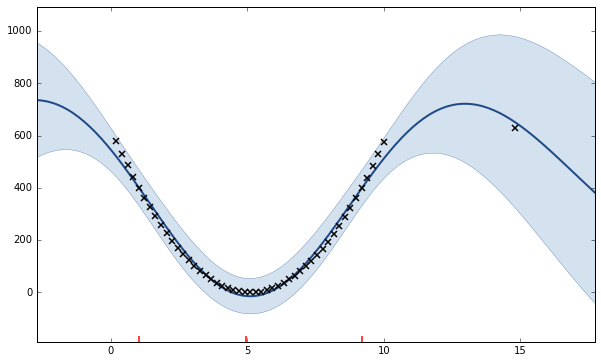

In [143]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
noise_var = 1
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+(np.arange(-N/2,N/2,1.)[:,None])**2
Z = np.linspace(0,10,M)[:,None]

newposes = np.arange(-5,15,0.2)
ind_positions = np.zeros((3,len(newposes)))
for i,newpos in enumerate(newposes):
    X[0] = newpos
    m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,i] = np.sort(m.inducing_inputs.values.squeeze())
m.plot()



(-5, 15)

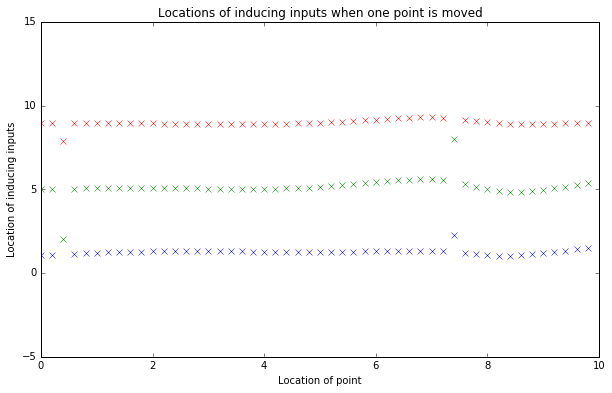

In [134]:
plt.plot(newposes,ind_positions.transpose(),'x')
plt.title('Locations of inducing inputs when one point is moved')
plt.xlabel('Location of point')
plt.ylabel('Location of inducing inputs')
plt.ylim([-5,15])

In [136]:
temp = ind_positions[:,np.sum(abs(ind_positions)>50,0)==0]
np.std(temp,1)
#np.std(ind_positions,1)

array([ 0.21405644,  2.09756862,  0.10882216])

The inducing inputs don't move much, across the range of inputs, with a standard deviation of less than 0.7. Note that the two locations where the values are very different is because we've got too many inducing inputs to explain such a simple shape.

If the data is clumped into two clusters, then the effect of the single point is much greater on the inducing inputs:

Populating the interactive namespace from numpy and matplotlib


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f36551ffbd0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f36551d0a10>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f365525c3d0>]}

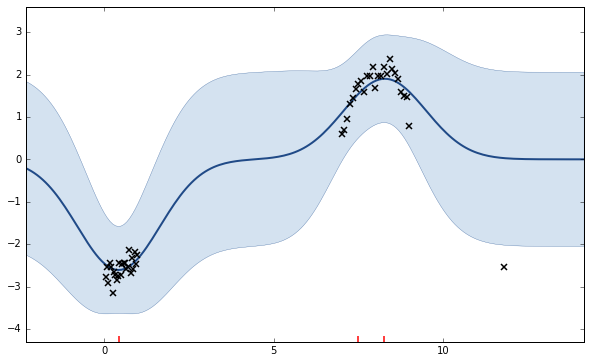

In [138]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
noise_var = 0.001
X = np.linspace(0,2,N)[:,None]
X[N/2:N] = np.linspace(7,9,N/2)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-N/2,N/2,1.)[:,None]*0.01
Z = np.linspace(0,10,M)[:,None]

newposes = np.arange(-2,12,0.2)
ind_positions = np.zeros((3,len(newposes)))
for i,newpos in enumerate(newposes):
    X[0] = newpos
    m = GPy.models.SparseGPRegression(X,y,Z=Z)
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,i] = np.sort(m.inducing_inputs.values.squeeze())
    
m.plot()


(-1, 11)

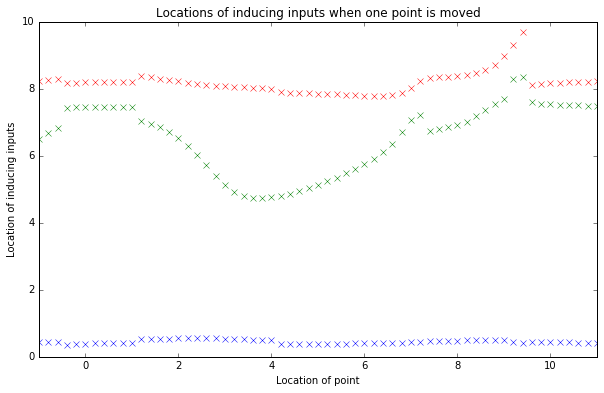

In [139]:
plt.plot(newposes,ind_positions.transpose(),'x')
plt.title('Locations of inducing inputs when one point is moved')
plt.xlabel('Location of point')
plt.ylabel('Location of inducing inputs')
plt.xlim([-1,11])

## Summary

Some data sets will be more susceptible to the movement of a data point than others. How likely are those datasets? And how likely is it that the point will land on a location which involves a large movement of the inducing inputs?

Both questions feel fairly domain specific.

Importantly if the data point becomes an outlier the inducing inputs will lie on top of it, which might show up later in the output.